Epoch 0: Loss = 1.52481e+05
Epoch 100: Loss = 6.42178e+04
Epoch 200: Loss = 6.41119e+04
Epoch 300: Loss = 6.40399e+04
Epoch 400: Loss = 6.39806e+04
Epoch 500: Loss = 6.39176e+04
Epoch 600: Loss = 6.38223e+04
Epoch 700: Loss = 6.36281e+04
Epoch 800: Loss = 6.31301e+04
Epoch 900: Loss = 6.13369e+04
Epoch 1000: Loss = 5.21885e+04
Epoch 1100: Loss = 4.04532e+04
Epoch 1200: Loss = 3.83605e+04
Epoch 1300: Loss = 3.72189e+04
Epoch 1400: Loss = 3.57384e+04
Epoch 1500: Loss = 3.32842e+04
Epoch 1600: Loss = 3.02276e+04
Epoch 1700: Loss = 2.77953e+04
Epoch 1800: Loss = 2.60777e+04
Epoch 1900: Loss = 2.45154e+04
Epoch 2000: Loss = 2.30568e+04
Epoch 2100: Loss = 2.19168e+04
Epoch 2200: Loss = 2.10123e+04
Epoch 2300: Loss = 2.02544e+04
Epoch 2400: Loss = 1.95895e+04
Epoch 2500: Loss = 1.89815e+04
Epoch 2600: Loss = 1.84226e+04
Epoch 2700: Loss = 1.78759e+04
Epoch 2800: Loss = 1.73461e+04
Epoch 2900: Loss = 1.68003e+04
Epoch 3000: Loss = 1.62459e+04
Epoch 3100: Loss = 1.57134e+04
Epoch 3200: Loss = 1

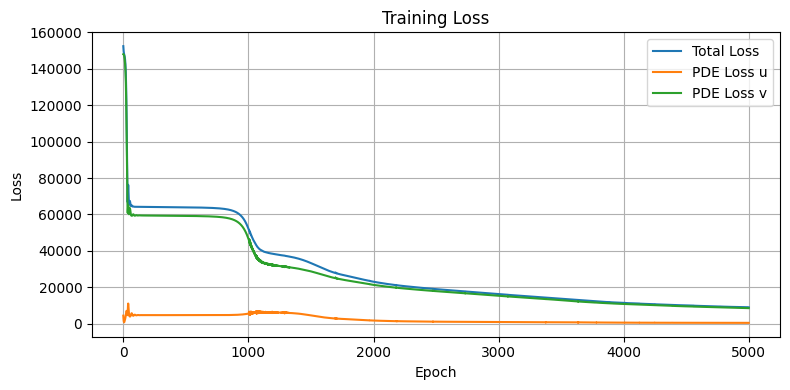

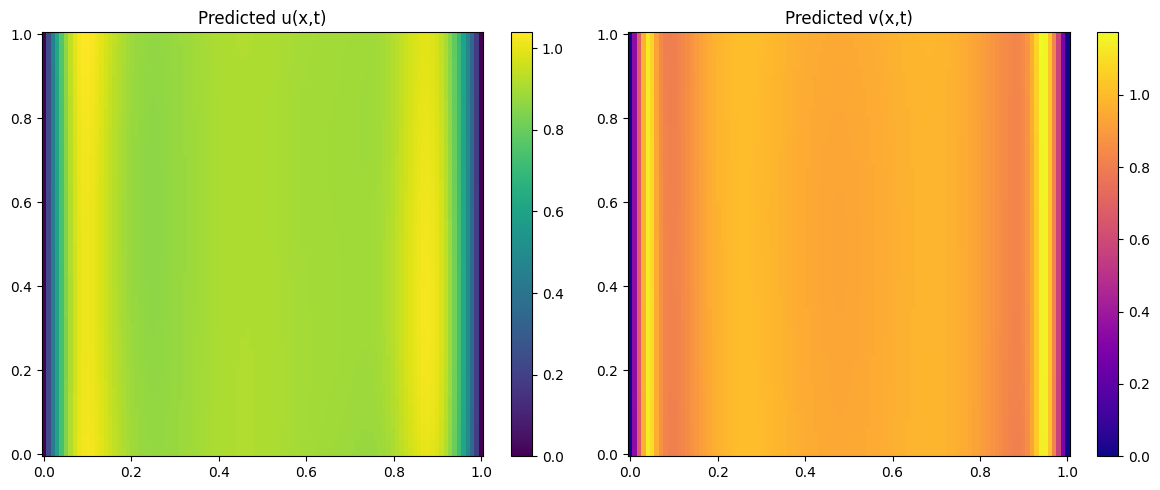

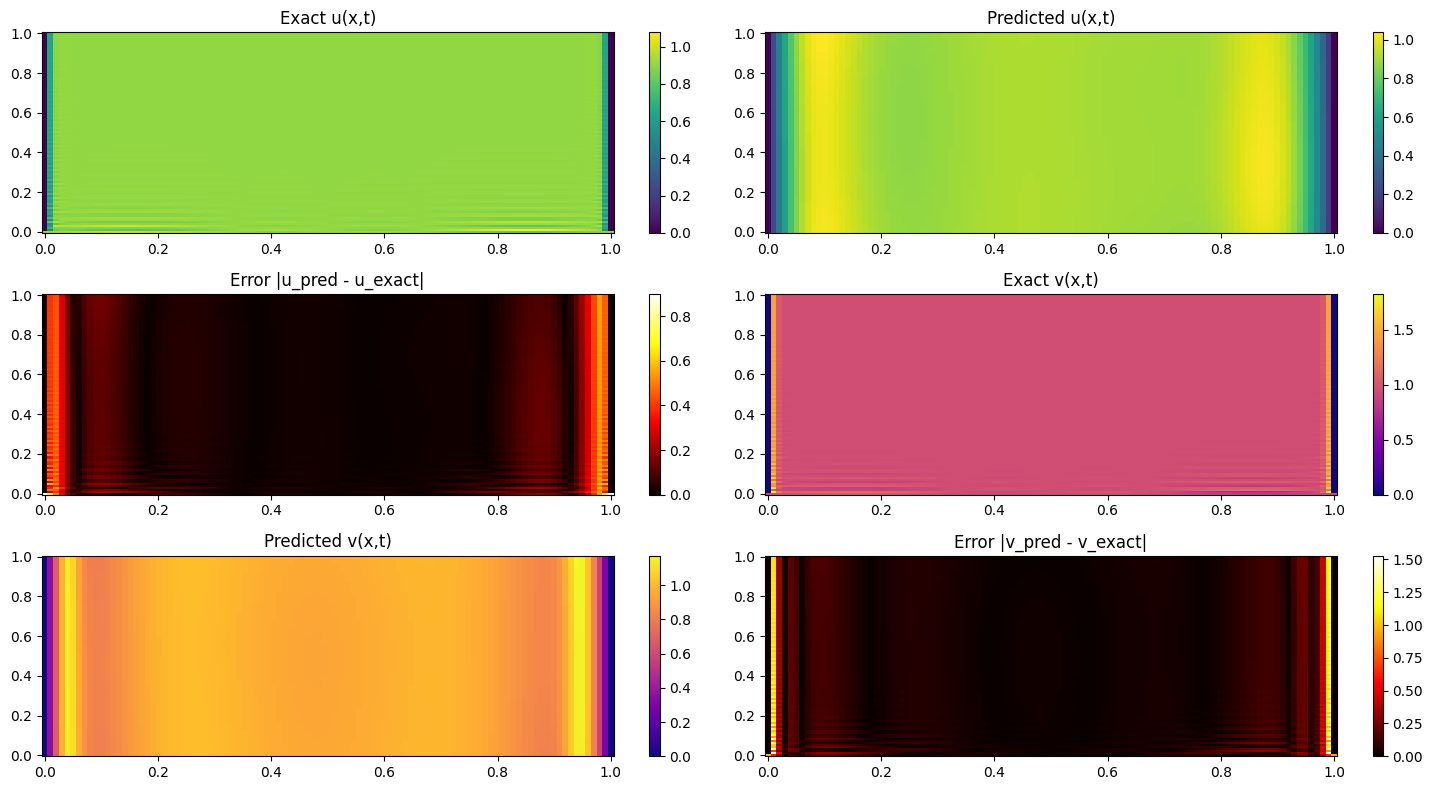

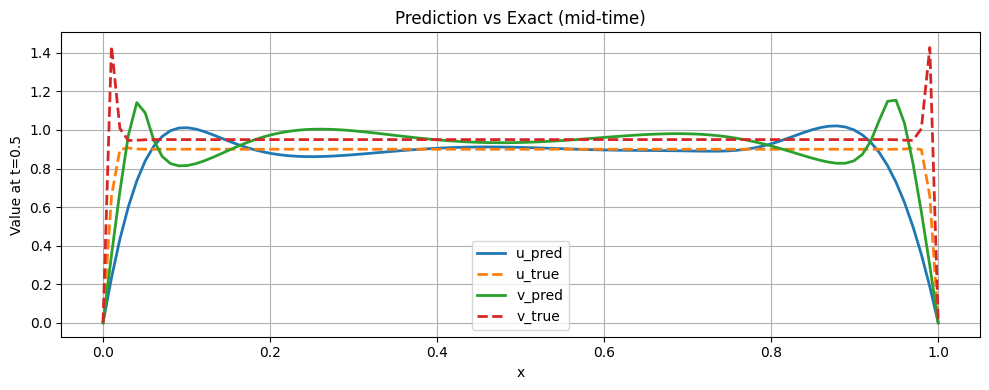

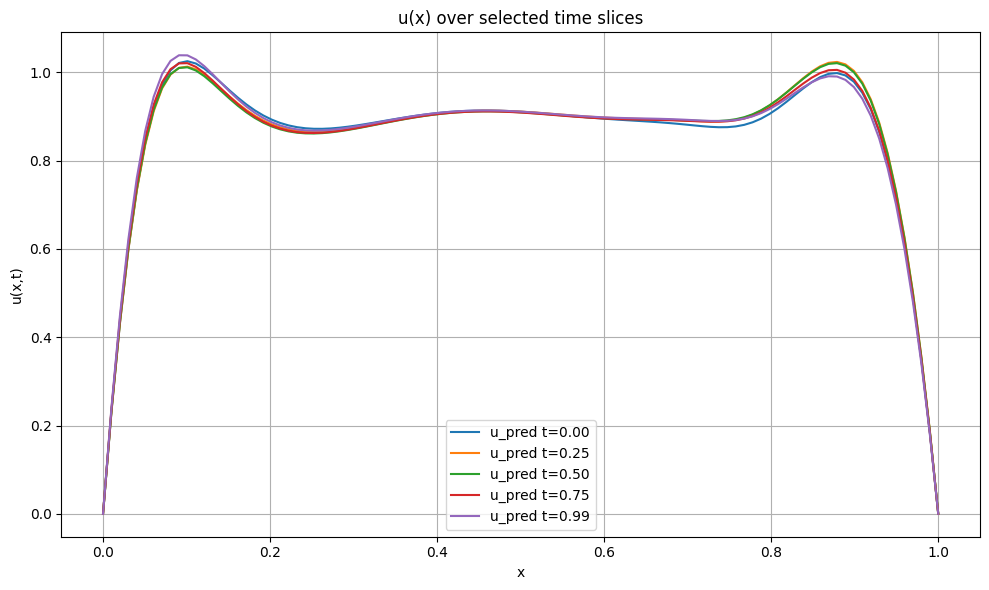

In [ ]:
# ----------------------------
# PINN for 1D Reaction-Diffusion System: Schnakenberg Model (Dual Network, Hard BC + Pattern Trigger)
# ----------------------------

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

# Set seed for reproducibility
torch.manual_seed(0)

# ## PDE Parameters
D_u = 1e-2
D_v = 5e-3
gamma = 500.0  # stronger reaction term
a = 0.1305
b = 0.7695

# ## Define PINN model with hard Dirichlet BC injection
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, t):
        xt = torch.cat([x, t], dim=1)
        return x * (1 - x) * self.net(xt)

u_net = PINN()
v_net = PINN()

# ## Training Data
N_f, N_i, N_b = 5000, 200, 1000
x_f = torch.rand(N_f, 1, requires_grad=True)
t_f = torch.rand(N_f, 1, requires_grad=True)
x_i = torch.rand(N_i, 1)
t_i = torch.zeros_like(x_i)

# Stronger asymmetric perturbation
u_i = a + b + 0.05 * (torch.sin(2 * np.pi * x_i) + torch.sin(4 * np.pi * x_i))
v_i = b / ((a + b)**2) + 0.05 * (torch.sin(2 * np.pi * x_i) + torch.sin(4 * np.pi * x_i))

x_b = torch.cat([torch.zeros(N_b//2,1), torch.ones(N_b//2,1)], dim=0)
t_b = torch.rand(N_b, 1)

# ## Loss Function
loss_u_list, loss_v_list = [], []

def loss_fn():
    u = u_net(x_f, t_f)
    v = v_net(x_f, t_f)

    u_t = torch.autograd.grad(u, t_f, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_f, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_f, torch.ones_like(u_x), create_graph=True)[0]

    v_t = torch.autograd.grad(v, t_f, torch.ones_like(v), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x_f, torch.ones_like(v), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x_f, torch.ones_like(v_x), create_graph=True)[0]

    f_u = u_t - D_u * u_xx - gamma * (a - u + u**2 * v)
    f_v = v_t - D_v * v_xx - gamma * (b - u**2 * v)

    loss_f_u = torch.mean(f_u**2)
    loss_f_v = torch.mean(f_v**2)
    loss_f = loss_f_u + loss_f_v

    u_pred_i = u_net(x_i, t_i)
    v_pred_i = v_net(x_i, t_i)
    loss_i = torch.mean((u_pred_i - u_i)**2) + torch.mean((v_pred_i - v_i)**2)

    u_b = u_net(x_b, t_b)
    v_b = v_net(x_b, t_b)
    loss_b = torch.mean(u_b**2) + torch.mean(v_b**2)

    loss_u_list.append(loss_f_u.item())
    loss_v_list.append(loss_f_v.item())

    return loss_f + 10 * loss_i + loss_b

# ## Train the Models
params = list(u_net.parameters()) + list(v_net.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)
loss_history = []

for epoch in range(5000):
    optimizer.zero_grad()
    loss = loss_fn()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.5e}")

# ## Predictions on Grid
x_vis = torch.linspace(0, 1, 100).reshape(-1,1)
t_vis = torch.linspace(0, 1, 100).reshape(-1,1)
X, T = torch.meshgrid(x_vis.squeeze(), t_vis.squeeze(), indexing='ij')
x_test = X.reshape(-1,1)
t_test = T.reshape(-1,1)

with torch.no_grad():
    u_pred = u_net(x_test, t_test).reshape(100,100)
    v_pred = v_net(x_test, t_test).reshape(100,100)

# ## Loss Curves
plt.figure(figsize=(8,4))
plt.plot(loss_history, label='Total Loss')
plt.plot(loss_u_list, label='PDE Loss u')
plt.plot(loss_v_list, label='PDE Loss v')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training Loss')
plt.tight_layout()
plt.show()

# ## Contour Predictions
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.pcolormesh(X, T, u_pred, shading='auto', cmap='viridis')
plt.colorbar()
plt.title('Predicted u(x,t)')
plt.subplot(1,2,2)
plt.pcolormesh(X, T, v_pred, shading='auto', cmap='plasma')
plt.colorbar()
plt.title('Predicted v(x,t)')
plt.tight_layout()
plt.show()

# ## Reference Solution via Finite Difference

def finite_diff_schnakenberg(dx=0.01, dt=1e-4, T=1.0):
    Nx = int(1 / dx) + 1
    Nt = int(T / dt) + 1
    x = np.linspace(0, 1, Nx)
    u = np.zeros((Nt, Nx))
    v = np.zeros((Nt, Nx))

    u[0] = a + b + 0.05 * (np.sin(2*np.pi*x) + np.sin(4*np.pi*x))
    v[0] = b / ((a + b)**2) + 0.05 * (np.sin(2*np.pi*x) + np.sin(4*np.pi*x))

    for n in range(0, Nt - 1):
        u_xx = np.zeros(Nx)
        v_xx = np.zeros(Nx)
        u_xx[1:-1] = (u[n,2:] - 2*u[n,1:-1] + u[n,:-2]) / dx**2
        v_xx[1:-1] = (v[n,2:] - 2*v[n,1:-1] + v[n,:-2]) / dx**2

        f_u = gamma * (a - u[n] + u[n]**2 * v[n])
        f_v = gamma * (b - u[n]**2 * v[n])

        u[n+1,1:-1] = u[n,1:-1] + dt * (D_u * u_xx[1:-1] + f_u[1:-1])
        v[n+1,1:-1] = v[n,1:-1] + dt * (D_v * v_xx[1:-1] + f_v[1:-1])

    return x, np.linspace(0, T, Nt), u, v

# ## Compare with Reference
x_ref, t_ref, u_ref, v_ref = finite_diff_schnakenberg()
interp_u = RegularGridInterpolator((t_ref, x_ref), u_ref)
interp_v = RegularGridInterpolator((t_ref, x_ref), v_ref)

X_np = X.numpy()
T_np = T.numpy()
pts = np.stack([T_np.flatten(), X_np.flatten()], axis=1)
u_true = interp_u(pts).reshape(100, 100)
v_true = interp_v(pts).reshape(100, 100)

error_u = np.abs(u_pred.numpy() - u_true)
error_v = np.abs(v_pred.numpy() - v_true)

plt.figure(figsize=(15,8))
plt.subplot(3,2,1)
plt.pcolormesh(X, T, u_true, shading='auto', cmap='viridis')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.subplot(3,2,2)
plt.pcolormesh(X, T, u_pred.numpy(), shading='auto', cmap='viridis')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.subplot(3,2,3)
plt.pcolormesh(X, T, error_u, shading='auto', cmap='hot')
plt.title('Error |u_pred - u_exact|')
plt.colorbar()
plt.subplot(3,2,4)
plt.pcolormesh(X, T, v_true, shading='auto', cmap='plasma')
plt.title('Exact v(x,t)')
plt.colorbar()
plt.subplot(3,2,5)
plt.pcolormesh(X, T, v_pred.numpy(), shading='auto', cmap='plasma')
plt.title('Predicted v(x,t)')
plt.colorbar()
plt.subplot(3,2,6)
plt.pcolormesh(X, T, error_v, shading='auto', cmap='hot')
plt.title('Error |v_pred - v_exact|')
plt.colorbar()
plt.tight_layout()
plt.show()

# ## Curve Comparison at Fixed Time
plt.figure(figsize=(10,4))
idx_t = 50
plt.plot(x_vis.numpy(), u_pred[:,idx_t], label='u_pred', linewidth=2)
plt.plot(x_vis.numpy(), u_true[:,idx_t], '--', label='u_true', linewidth=2)
plt.plot(x_vis.numpy(), v_pred[:,idx_t], label='v_pred', linewidth=2)
plt.plot(x_vis.numpy(), v_true[:,idx_t], '--', label='v_true', linewidth=2)
plt.xlabel('x')
plt.ylabel('Value at t=0.5')
plt.title('Prediction vs Exact (mid-time)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ## Bonus: Pattern Emergence Over Time
plt.figure(figsize=(10,6))
for t_idx in [0, 25, 50, 75, 99]:
    plt.plot(x_vis.numpy(), u_pred[:,t_idx], label=f"u_pred t={t_idx/100:.2f}")
plt.title("u(x) over selected time slices")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 0: Loss = 1.52472e+06
Epoch 100: Loss = 6.42161e+05
Epoch 200: Loss = 6.41102e+05
Epoch 300: Loss = 6.40381e+05
Epoch 400: Loss = 6.39788e+05
Epoch 500: Loss = 6.39157e+05
Epoch 600: Loss = 6.38200e+05
Epoch 700: Loss = 6.36251e+05
Epoch 800: Loss = 6.31252e+05
Epoch 900: Loss = 6.13226e+05
Epoch 1000: Loss = 5.21174e+05
Epoch 1100: Loss = 4.03526e+05
Epoch 1200: Loss = 3.83056e+05
Epoch 1300: Loss = 3.71680e+05
Epoch 1400: Loss = 3.56813e+05
Epoch 1500: Loss = 3.31765e+05
Epoch 1600: Loss = 3.01101e+05
Epoch 1700: Loss = 2.76951e+05
Epoch 1800: Loss = 2.60134e+05
Epoch 1900: Loss = 2.44074e+05
Epoch 2000: Loss = 2.29947e+05
Epoch 2100: Loss = 2.18663e+05
Epoch 2200: Loss = 2.09808e+05
Epoch 2300: Loss = 2.02369e+05
Epoch 2400: Loss = 1.95876e+05
Epoch 2500: Loss = 1.89800e+05
Epoch 2600: Loss = 1.84118e+05
Epoch 2700: Loss = 1.78727e+05
Epoch 2800: Loss = 1.73431e+05
Epoch 2900: Loss = 1.67915e+05
Epoch 3000: Loss = 1.62421e+05
Epoch 3100: Loss = 1.56930e+05
Epoch 3200: Loss = 1

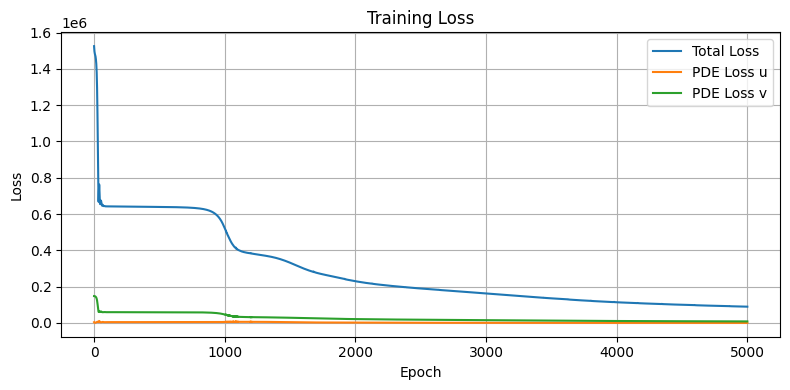

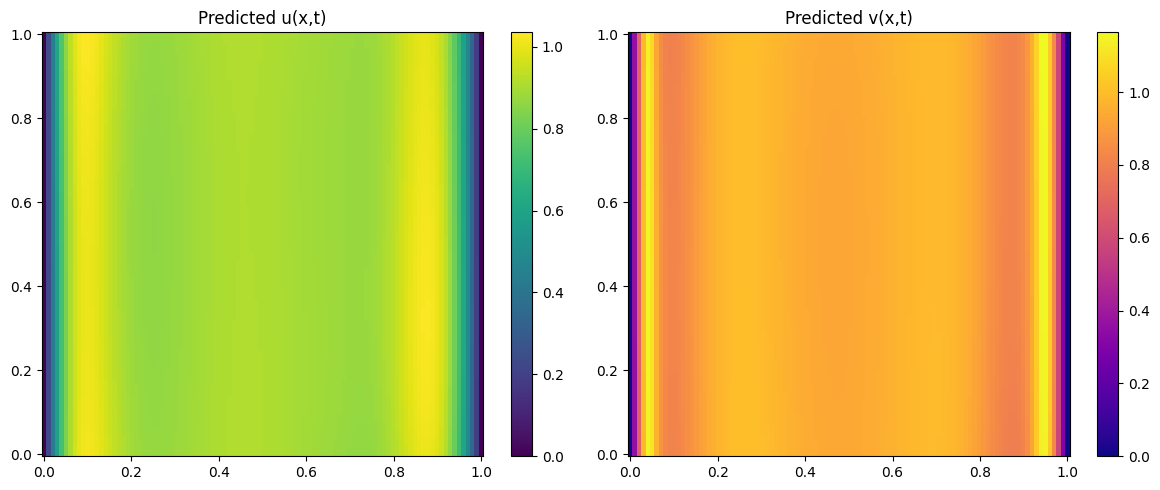

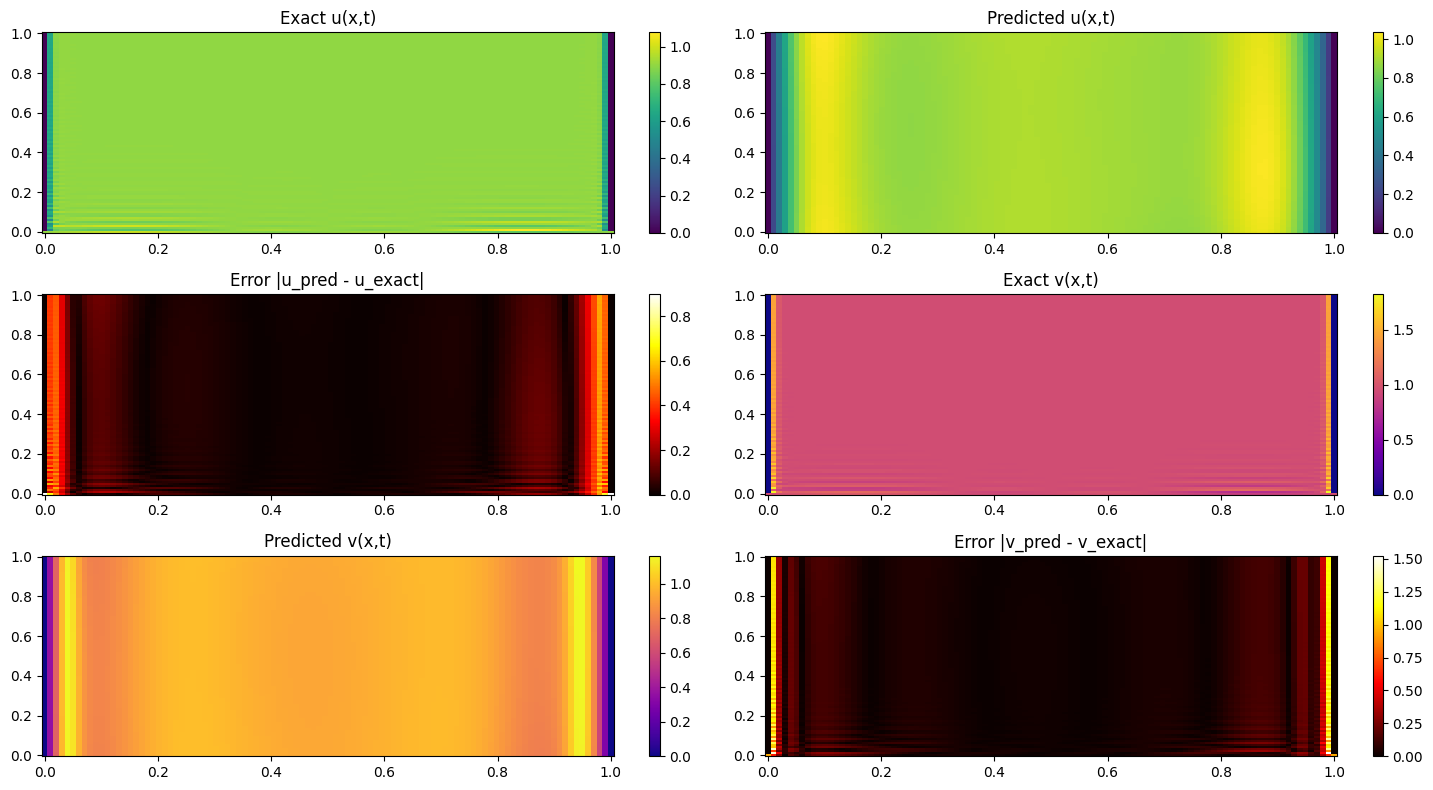

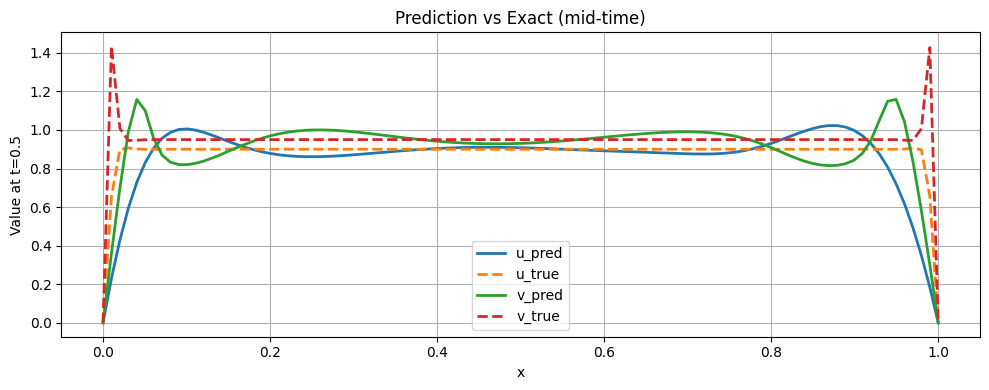

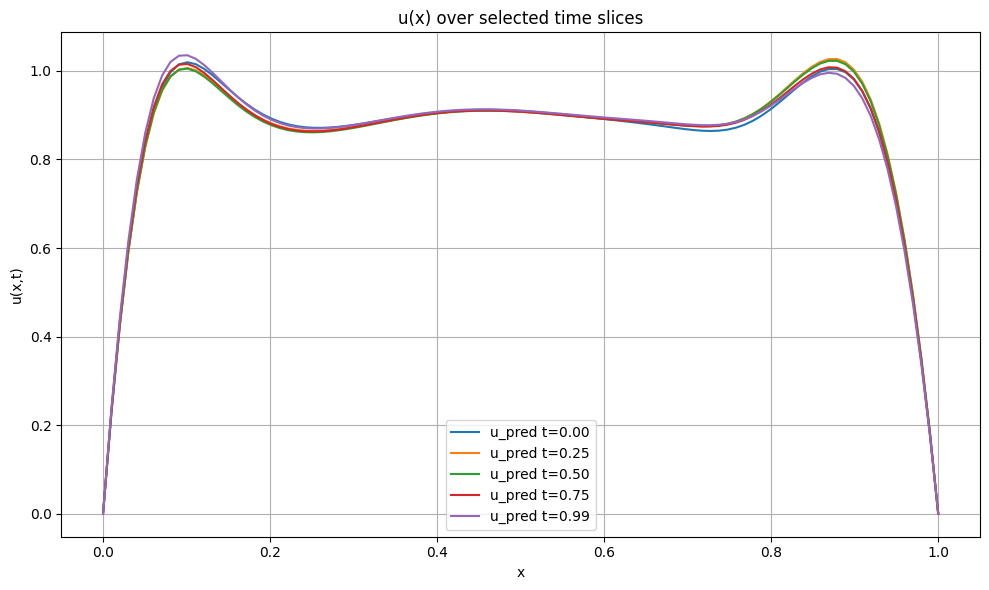

In [3]:
# ----------------------------
# PINN for 1D Reaction-Diffusion System: Schnakenberg Model (Dual Network, Hard BC + Pattern Trigger)
# ----------------------------

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

# Set seed for reproducibility
torch.manual_seed(0)

# ## PDE Parameters
D_u = 1e-2
D_v = 5e-3
gamma = 500.0  # stronger reaction term
a = 0.1305
b = 0.7695

# ## Define PINN model with hard Dirichlet BC injection
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, t):
        xt = torch.cat([x, t], dim=1)
        return x * (1 - x) * self.net(xt)

u_net = PINN()
v_net = PINN()

# ## Training Data
N_f, N_i, N_b = 5000, 200, 1000
x_f = torch.rand(N_f, 1, requires_grad=True)
t_f = torch.rand(N_f, 1, requires_grad=True)
x_i = torch.rand(N_i, 1)
t_i = torch.zeros_like(x_i)

# Stronger asymmetric perturbation
u_i = a + b + 0.05 * (torch.sin(2 * np.pi * x_i) + torch.sin(4 * np.pi * x_i))
v_i = b / ((a + b)**2) + 0.05 * (torch.sin(2 * np.pi * x_i) + torch.sin(4 * np.pi * x_i))

x_b = torch.cat([torch.zeros(N_b//2,1), torch.ones(N_b//2,1)], dim=0)
t_b = torch.rand(N_b, 1)

# ## Loss Function
loss_u_list, loss_v_list = [], []

# Loss weight coefficients
lambda_f = 10.0
lambda_i = 50.0
lambda_b = 20.0

def loss_fn():
    u = u_net(x_f, t_f)
    v = v_net(x_f, t_f)

    u_t = torch.autograd.grad(u, t_f, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_f, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_f, torch.ones_like(u_x), create_graph=True)[0]

    v_t = torch.autograd.grad(v, t_f, torch.ones_like(v), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x_f, torch.ones_like(v), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x_f, torch.ones_like(v_x), create_graph=True)[0]

    f_u = u_t - D_u * u_xx - gamma * (a - u + u**2 * v)
    f_v = v_t - D_v * v_xx - gamma * (b - u**2 * v)

    loss_f_u = torch.mean(f_u**2)
    loss_f_v = torch.mean(f_v**2)
    loss_f = loss_f_u + loss_f_v

    u_pred_i = u_net(x_i, t_i)
    v_pred_i = v_net(x_i, t_i)
    loss_i = torch.mean((u_pred_i - u_i)**2) + torch.mean((v_pred_i - v_i)**2)

    u_b = u_net(x_b, t_b)
    v_b = v_net(x_b, t_b)
    loss_b = torch.mean(u_b**2) + torch.mean(v_b**2)

    loss_u_list.append(loss_f_u.item())
    loss_v_list.append(loss_f_v.item())

    return lambda_f * loss_f + lambda_i * loss_i + lambda_b * loss_b

# ## Train the Models
params = list(u_net.parameters()) + list(v_net.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)
loss_history = []

for epoch in range(5000):
    optimizer.zero_grad()
    loss = loss_fn()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.5e}")

# ## Predictions on Grid
x_vis = torch.linspace(0, 1, 100).reshape(-1,1)
t_vis = torch.linspace(0, 1, 100).reshape(-1,1)
X, T = torch.meshgrid(x_vis.squeeze(), t_vis.squeeze(), indexing='ij')
x_test = X.reshape(-1,1)
t_test = T.reshape(-1,1)

with torch.no_grad():
    u_pred = u_net(x_test, t_test).reshape(100,100)
    v_pred = v_net(x_test, t_test).reshape(100,100)

# ## Loss Curves
plt.figure(figsize=(8,4))
plt.plot(loss_history, label='Total Loss')
plt.plot(loss_u_list, label='PDE Loss u')
plt.plot(loss_v_list, label='PDE Loss v')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training Loss')
plt.tight_layout()
plt.show()

# ## Contour Predictions
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.pcolormesh(X, T, u_pred, shading='auto', cmap='viridis')
plt.colorbar()
plt.title('Predicted u(x,t)')
plt.subplot(1,2,2)
plt.pcolormesh(X, T, v_pred, shading='auto', cmap='plasma')
plt.colorbar()
plt.title('Predicted v(x,t)')
plt.tight_layout()
plt.show()

# ## Reference Solution via Finite Difference

def finite_diff_schnakenberg(dx=0.01, dt=1e-4, T=1.0):
    Nx = int(1 / dx) + 1
    Nt = int(T / dt) + 1
    x = np.linspace(0, 1, Nx)
    u = np.zeros((Nt, Nx))
    v = np.zeros((Nt, Nx))

    u[0] = a + b + 0.05 * (np.sin(2*np.pi*x) + np.sin(4*np.pi*x))
    v[0] = b / ((a + b)**2) + 0.05 * (np.sin(2*np.pi*x) + np.sin(4*np.pi*x))

    for n in range(0, Nt - 1):
        u_xx = np.zeros(Nx)
        v_xx = np.zeros(Nx)
        u_xx[1:-1] = (u[n,2:] - 2*u[n,1:-1] + u[n,:-2]) / dx**2
        v_xx[1:-1] = (v[n,2:] - 2*v[n,1:-1] + v[n,:-2]) / dx**2

        f_u = gamma * (a - u[n] + u[n]**2 * v[n])
        f_v = gamma * (b - u[n]**2 * v[n])

        u[n+1,1:-1] = u[n,1:-1] + dt * (D_u * u_xx[1:-1] + f_u[1:-1])
        v[n+1,1:-1] = v[n,1:-1] + dt * (D_v * v_xx[1:-1] + f_v[1:-1])

    return x, np.linspace(0, T, Nt), u, v

# ## Compare with Reference
x_ref, t_ref, u_ref, v_ref = finite_diff_schnakenberg()
interp_u = RegularGridInterpolator((t_ref, x_ref), u_ref)
interp_v = RegularGridInterpolator((t_ref, x_ref), v_ref)

X_np = X.numpy()
T_np = T.numpy()
pts = np.stack([T_np.flatten(), X_np.flatten()], axis=1)
u_true = interp_u(pts).reshape(100, 100)
v_true = interp_v(pts).reshape(100, 100)

error_u = np.abs(u_pred.numpy() - u_true)
error_v = np.abs(v_pred.numpy() - v_true)

plt.figure(figsize=(15,8))
plt.subplot(3,2,1)
plt.pcolormesh(X, T, u_true, shading='auto', cmap='viridis')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.subplot(3,2,2)
plt.pcolormesh(X, T, u_pred.numpy(), shading='auto', cmap='viridis')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.subplot(3,2,3)
plt.pcolormesh(X, T, error_u, shading='auto', cmap='hot')
plt.title('Error |u_pred - u_exact|')
plt.colorbar()
plt.subplot(3,2,4)
plt.pcolormesh(X, T, v_true, shading='auto', cmap='plasma')
plt.title('Exact v(x,t)')
plt.colorbar()
plt.subplot(3,2,5)
plt.pcolormesh(X, T, v_pred.numpy(), shading='auto', cmap='plasma')
plt.title('Predicted v(x,t)')
plt.colorbar()
plt.subplot(3,2,6)
plt.pcolormesh(X, T, error_v, shading='auto', cmap='hot')
plt.title('Error |v_pred - v_exact|')
plt.colorbar()
plt.tight_layout()
plt.show()

# ## Curve Comparison at Fixed Time
plt.figure(figsize=(10,4))
idx_t = 50
plt.plot(x_vis.numpy(), u_pred[:,idx_t], label='u_pred', linewidth=2)
plt.plot(x_vis.numpy(), u_true[:,idx_t], '--', label='u_true', linewidth=2)
plt.plot(x_vis.numpy(), v_pred[:,idx_t], label='v_pred', linewidth=2)
plt.plot(x_vis.numpy(), v_true[:,idx_t], '--', label='v_true', linewidth=2)
plt.xlabel('x')
plt.ylabel('Value at t=0.5')
plt.title('Prediction vs Exact (mid-time)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ## Bonus: Pattern Emergence Over Time
plt.figure(figsize=(10,6))
for t_idx in [0, 25, 50, 75, 99]:
    plt.plot(x_vis.numpy(), u_pred[:,t_idx], label=f"u_pred t={t_idx/100:.2f}")
plt.title("u(x) over selected time slices")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Current Observations and Challenges

Despite successfully training the PINN model on the 1D Schnakenberg reaction-diffusion system, two major issues remain:

1. **Large prediction errors near boundaries**  
   The predicted values at \( x = 0 \) and \( x = 1 \) significantly deviate from the reference solution. This suggests the model struggles to capture accurate behavior near the domain edges.

2. **Unrealistically flat solution in the center**  
   At intermediate times (e.g., \( t = 0.5 \)), the predicted profile is nearly flat in the middle of the domain, which contradicts the spatial variation shown by the reference solution.

To mitigate these problems, we restructured the loss function to assign individual weights to each term:

- \( $\lambda_f$ = 10.0 \): PDE residual loss weight  
- \( $\lambda_i$ = 50.0 \): Initial condition loss weight  
- \( $\lambda_b$ = 20.0 \): Boundary condition loss weight  

These weights are now manually tunable hyperparameters. While this update provides better control, the optimal configuration remains under investigation. Future work will explore additional strategies, such as architectural changes, adaptive sampling near boundaries, and enhanced training schedules.
